In [1]:
%pylab inline
import numpy as np
import torch
import os
import pandas as pd

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
from torch.autograd import Variable
import nibabel as nib
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from nilearn import plotting
from ADNI_dataset import *
from BRATS_dataset import *
from ATLAS_dataset import *
from utils import *

import pytorch_ssim
from ipdb import set_trace

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
# used to store the MMD ans MS-SSIM
try:
    os.mkdir('./test_data')
except FileExistsError:
    pass
gpu = True
workers = 4
BATCH_SIZE = 8
latent_dim = 1000

Use_BRATS = False
Use_ATLAS = False

In [3]:
trainset = ADNIdataset(augmentation=True)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
#'flair' or 't2' or 't1ce'
# trainset = BRATSdataset(imgtype='flair')
# train_loader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE, shuffle=True,
#                                                num_workers=workers)

# trainset = ATLASdataset(augmentation=True)
# train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)

gen_load = inf_train_gen(train_loader)

## Pre-trained Generator Load

In [4]:
#-------------------------------------------
#Choose the Model you want!
from Model_alphaWGAN import Generator
from Model_alphaWGAN import Discriminator
# from Model_alphaGAN import Generator
# from Model_VAEGAN import Generator
# from Model_WGAN import Generator
#-------------------------------------------

G = Generator(noise=latent_dim).cuda()
# E = Discriminator(out_class = latent_dim, is_dis=False)
#-----------------------
#Load Pre-trained model
#-----------------------

#------------Trained Model of ADNI dataset---------------------
G.load_state_dict(torch.load('./checkpoint/G_iter12000.pth')) # Alpha-WGAN-GP
# E.load_state_dict(torch.load('./trained/E_iter12500.pth')) # Alpha-WGAN-GP Encoder
# G.load_state_dict(torch.load('./trained/G_VG_iter24552.pth')) #VAE-GAN
# G.load_state_dict(torch.load('./checkpoint/Alpha_G.pth')) #Alpha-GAN
# G.load_state_dict(torch.load('./checkpoint/G_W_iter3000.pth')) #WGAN-GP

#------------Trained Model of ATLAS dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/Ours_at_G.pth'))

#------------Trained Models of BRATS dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/Ours_fl_G.pth'))
# G.load_state_dict(torch.load('./checkpoint/Ours_t2_G.pth'))

Fake Image - slice series visualization

You can change the axis (x , y , z ) by changing  display_mode = 'x' / 'y' / 'z'

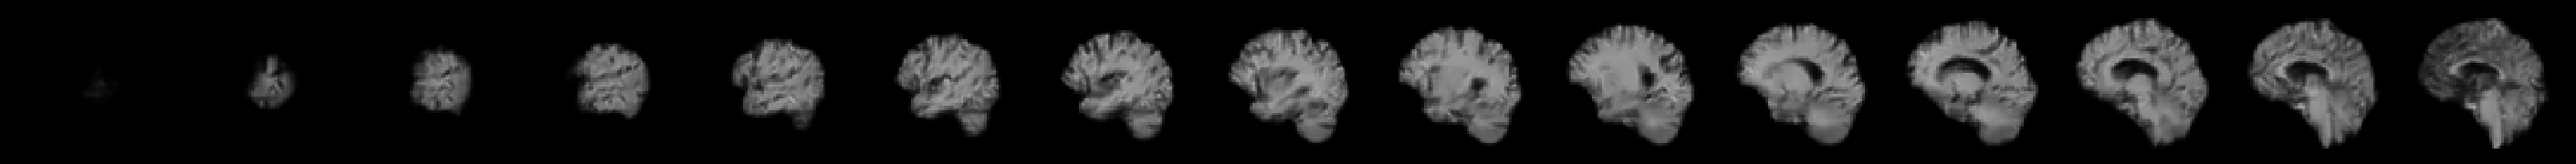

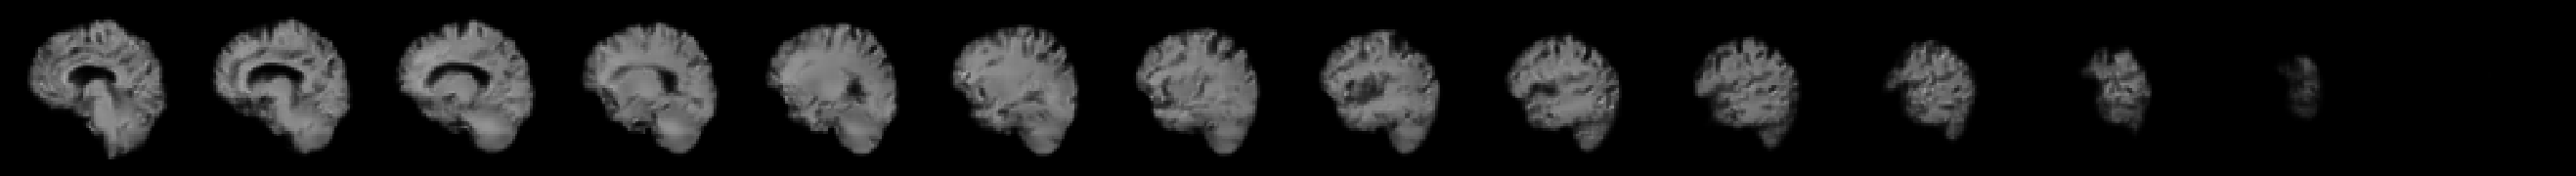

In [5]:
Show_color = False

noise = torch.randn(1, latent_dim).cuda()
fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))

arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]
if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False,positions=True)
    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

Fake Image - Center cut slices Visualization

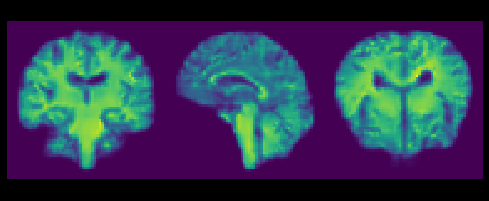

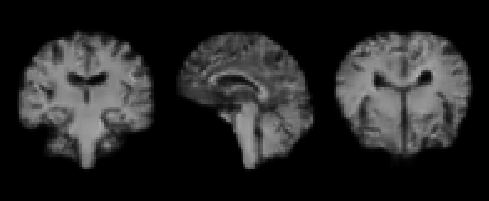

In [21]:
noise = Variable(torch.randn((1, 1000)).cuda())
# fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
plotting.plot_img(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.plot_anat(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.show()

Real Image - Slice series visualization

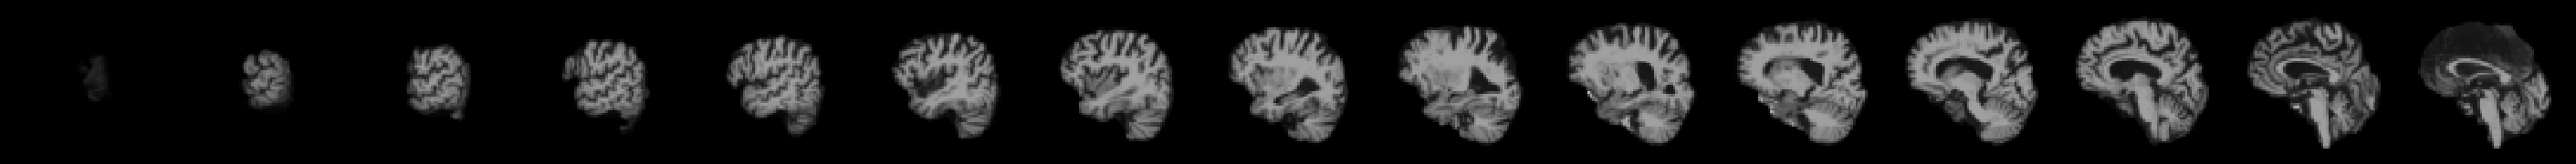

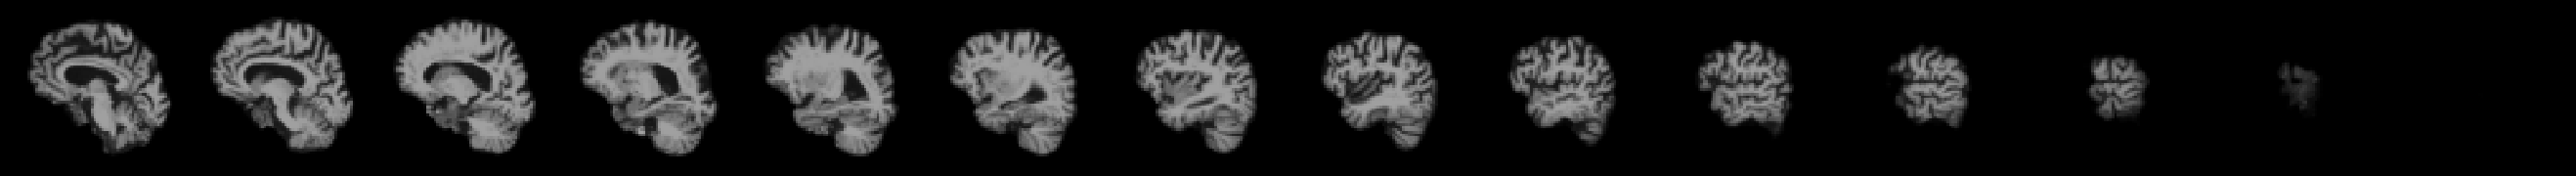

In [22]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)
gen_load = inf_train_gen(train_loader)

Show_color = False

image = gen_load.__next__()
featmask = np.squeeze(image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]

if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False,positions=True)
    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

# MS-SSIM Calculation

In [ ]:
# sum_ssim = 0
# for k in range(20):
#     for i,dat in enumerate(train_loader):
#         if len(dat)!=2:
#             break
#         img1 = dat[0]
#         img2 = dat[1]

#         msssim = pytorch_ssim.msssim_3d(img1,img2)
#         sum_ssim = sum_ssim+msssim
#     print(sum_ssim/((k+1)*(i+1)))

In [ ]:
sum_ssim = 0
for i in range(1000):
    noise = Variable(torch.randn((2, 1000)).cuda())
    fake_image = G(noise)

    img1 = fake_image[0]
    img2 = fake_image[1]

    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    if i % 100 == 0:
        print(sum_ssim/1000)
print(sum_ssim/1000)

# MS-SSIM for real images

In [ ]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)
test_loader = inf_train_gen(train_loader)
i = 0
sum_ssim = 0
while i < 494:
    img1, img2 = test_loader.__next__()
    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    i += 1
    if i % 100 == 0:
        print(i, sum_ssim/ (494 * 2))
        
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)
test_loader = inf_train_gen(train_loader)
while i < 494 * 2:
    img1, img2 = test_loader.__next__()
    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    i += 1
    if i % 100 == 0:
        print(i, sum_ssim/ (494 * 2))
print(sum_ssim/(494 * 2))

# Maximum-Mean Discrepancy Score

In [ ]:
# read csv if exists
if os.path.exists('./test_data/mmd.csv'):
    # get the latest index
    df = pd.read_csv('./test_data/mmd.csv')
    start = int(df.iloc[-1]['index'])
else:
    df = pd.DataFrame({'index': [], 'mmd_score': []})
    start = 0 

for p in G.parameters():
    p.requires_grad = False
for s in range(start, 100):
    distmean = 0.0
    for i,(y) in enumerate(train_loader):
        y = Variable(y).cuda()
        noise = Variable(torch.randn((y.size(0), 1000)).cuda())
        x = G(noise)
        B = y.size(0)
        x = x.view(x.size(0), x.size(2) * x.size(3)*x.size(4))
        y = y.view(y.size(0), y.size(2) * y.size(3)*y.size(4))

        xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

        beta = (1./(B*B))
        gamma = (2./(B*B)) 

        Dist = beta * (torch.sum(xx)+torch.sum(yy)) - gamma * torch.sum(zz)
        distmean += Dist

    mean = (distmean/(i+1)).item()
    print(f'\nCount: {s} Mean: {mean}')
    # write scores to csv
    df = df.append(pd.DataFrame({
        'index': [s],
        'mmd_score': [mean]
    }))
    df.to_csv('./test_data/mmd.csv', index=False)

meanarr = numpy.array(df.iloc[:]['mmd_score'].tolist())
print('Total_mean:'+str(np.mean(meanarr))+' STD:'+str(np.std(meanarr)))

### calculate mmd

In [ ]:
df = pd.read_csv('./test_data/mmd.csv')
mmds = np.array(df.iloc[:]['mmd_score'].to_list())
mmds.mean()

### visualize loss

In [ ]:
df = pd.read_csv('./trained/VAE_loss.csv')
y_arr = df.iloc[:]['loss:'].to_list()
x_arr = [i * 248 for i in range(len(y_arr))]
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(x_arr, y_arr)
plt.show()

In [ ]:
ind_arr = df.iloc[:]['index'].to_list()
[(ind_arr[i], x_arr[i]) for i in range(len(ind_arr))]

### Images PCA Visualization

index: 0


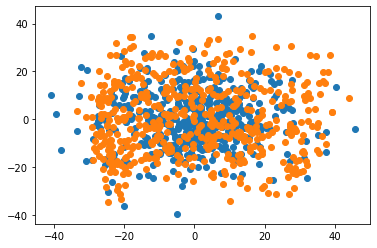

index: 500


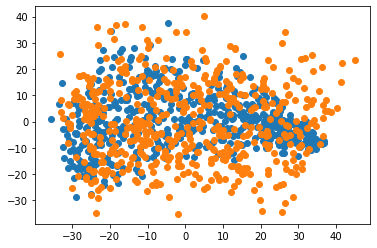

index: 1000


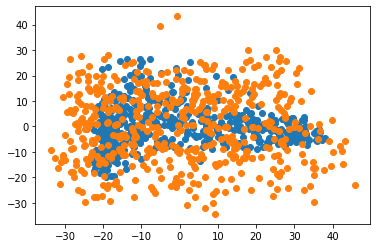

index: 1500


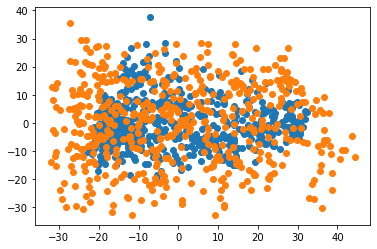

index: 2000


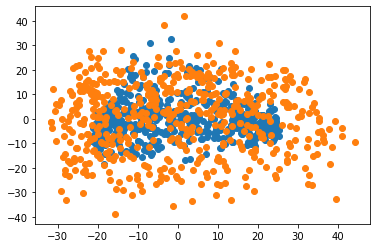

index: 2500


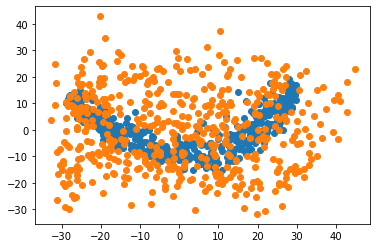

index: 3000


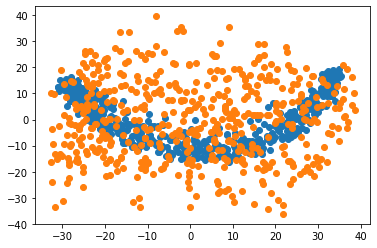

index: 3500


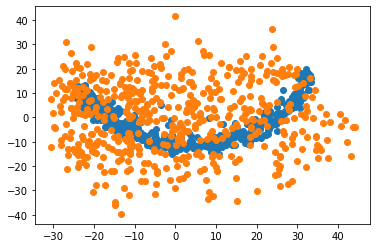

index: 4000


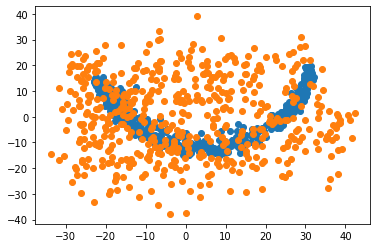

index: 4500


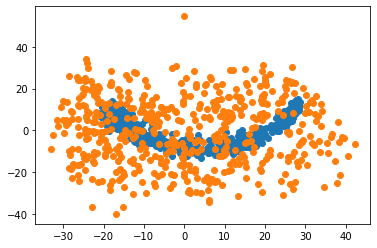

index: 5000


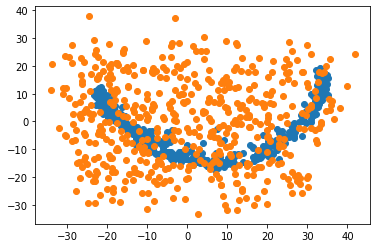

index: 5500


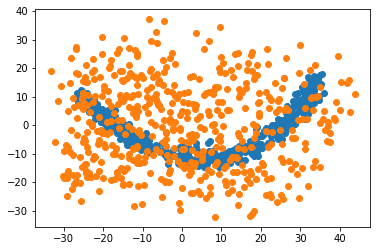

index: 6000


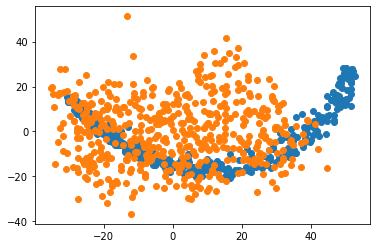

index: 6500


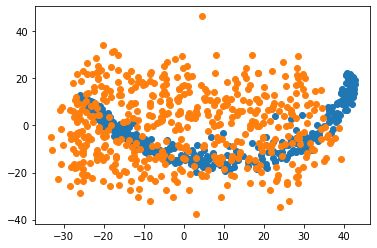

index: 7000


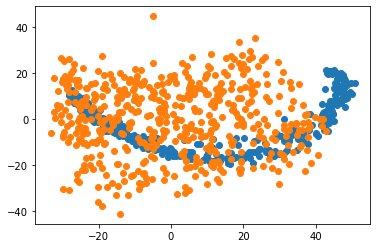

index: 7500


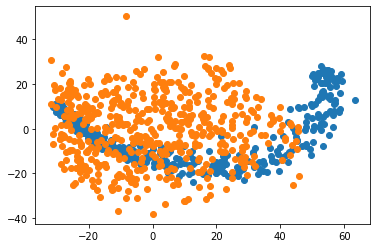

index: 8000


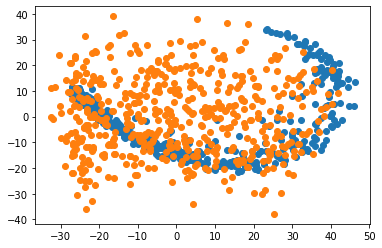

index: 8500


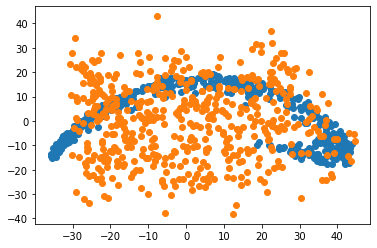

index: 9000


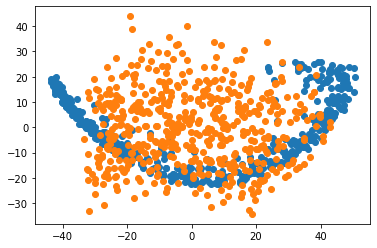

index: 9500


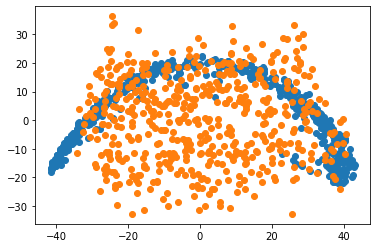

index: 10000


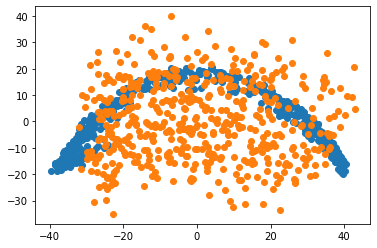

index: 10500


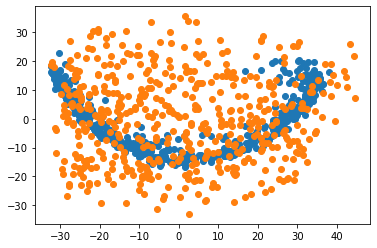

index: 11000


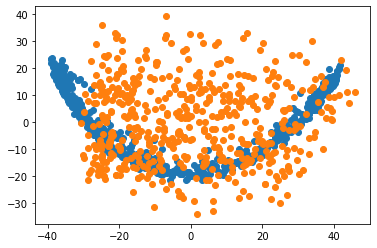

index: 11500


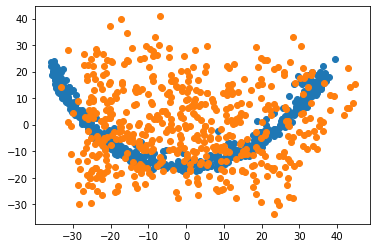

index: 12000


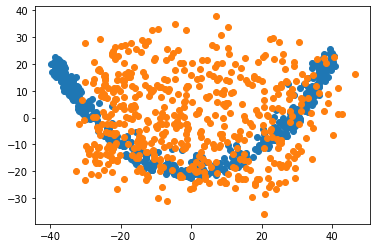

In [7]:
sample_df = pd.DataFrame()
real_df = pd.DataFrame()
for i in range(0, 12001, 500):
    G.load_state_dict(torch.load(f'./checkpoint/G_iter{i}.pth'))
    viz_pca(G, trainset, latent_size=latent_dim, index=i)

In [4]:
def show_pca_cluster(x, PC_list, interval=3):
    for i in range(x, x+interval):
        sample_ind = PC_list[i][2]
        feat = sample_df.iloc[int(sample_ind)].to_numpy().reshape((64, 64, 64))
        featmask = nib.Nifti1Image(feat,affine = np.eye(4))
        plotting.plot_img(featmask, title=f'x_val: {round(PC_list[i][0], 2)} y_val: {round(PC_list[i][1], 2)} sample_index: {int(sample_ind)}')
        plotting.show()

# concatenate the sample index 
PC_list = list(np.concatenate((PCs, np.array([i for i in range(512)]).reshape(512, 1)), 1))
# sort by x or y of PCAs
PC_list.sort(key=lambda x: x[1])

# for i in range(0, 512, 60):
#     show_pca_cluster(i, PC_list, 1)

show_pca_cluster(0, PC_list, 10)



NameError: name 'PCs' is not defined

### visualize all training images

In [5]:
viz_all_imgs('../../ADNI', [0])

FileNotFoundError: [Errno 2] No such file or directory: '../../ADNI'

### loss check

       index   l1_loss    d_recon     d_fake     d_real      d_loss  \
0          0  7.937310  -0.180844  -0.074949 -10.398265    0.255792   
1          1  6.921858  -3.850500  -1.966031 -15.553179    5.816531   
2          2  5.873695   3.211260   2.957075 -18.799953   -6.168335   
3          3  5.024762   4.234090   2.467319 -22.199413   -6.701409   
4          4  3.955197   7.465332   2.945585 -28.004450  -10.410917   
...      ...       ...        ...        ...        ...         ...   
17780  17780  0.782175 -53.581081 -53.828751  96.179810  107.409836   
17781  17781  0.769209 -58.956287 -54.129868  94.306519  113.086151   
17782  17782  0.857208 -61.019104 -54.527363  99.652664  115.546463   
17783  17783  0.802753 -56.751900 -52.158253  91.787323  108.910156   
17784  17784  0.733177 -62.185944 -55.948372  89.351753  118.134315   

            cd_loss      gp_r      gp_h       gp_cd         loss1      loss2  \
0         -0.090312  5.206463  8.459229    4.836048      8.102791  

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

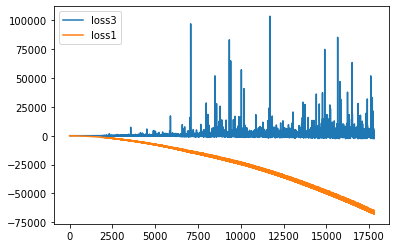

<Figure size 28800x28800 with 0 Axes>

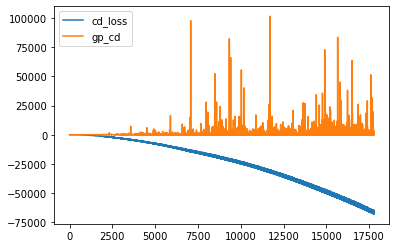

<Figure size 432x288 with 0 Axes>

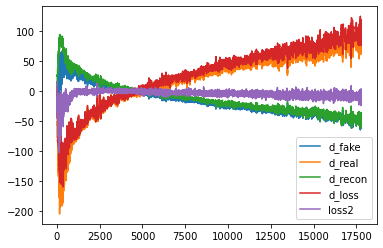

<Figure size 432x288 with 0 Axes>

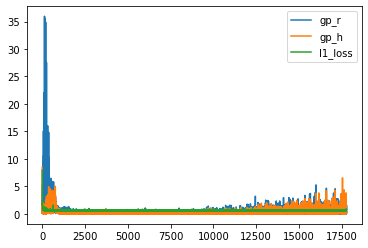

In [6]:
loss_df = load_loss(path='./test_data/loss.csv')
print(loss_df)
plt.figure()
loss_df[['loss3', 'loss1']].plot()
plt.figure(figsize=(400, 400))
loss_df[['cd_loss', 'gp_cd']].plot()
plt.figure()
loss_df[['d_fake', 'd_real', 'd_recon', 'd_loss', 'loss2']].plot()
plt.figure()
loss_df[['gp_r', 'gp_h', 'l1_loss']].plot()

### Calculate the paddings of fake images

In [ ]:
G = Generator(noise=1000).cuda()
G.load_state_dict(torch.load('./trained/G_iter12500.pth'))

def get_padding(feat, axis=0):
    feat = np.swapaxes(feat, 0, axis)
    output = [0, 0]
    for i in range(feat.shape[0]):
#         print(feat[i].sum())
        if feat[i].sum() > -4000:
            output[0] = i
            break
    for i in range(feat.shape[0] - 1, -1, -1):
        if feat[i].sum() > -4000:
            output[1] = feat.shape[0] - i - 1
            break
    return output
    
for i in range(512):
    noise = torch.rand((1, 1000)).cuda()
    img = G(noise)
    featmask = np.squeeze((0.5*img+0.5).detach().cpu().numpy())
    print(f'ind: {i} padding 0-axis: {get_padding(featmask, 0)}', end=' ')
    print(f'ind: {i} padding 1-axis: {get_padding(featmask, 1)}', end=' ')
    print(f'ind: {i} padding 2-axis: {get_padding(featmask, 2)}')
#     featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
#     plotting.plot_img(featmask, title=f'ind: {i}')
#     plotting.show()

### intensity range check

In [8]:
trainset = ADNIdataset(augmentation=True, img_size=64, normalization=False)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
for featmask in inf_train_gen(train_loader):
#     noise = torch.rand((1, 1000)).cuda()
#     featmask= G(noise)
#     featmask = np.squeeze((0.5*featmask+0.5).detach().cpu().numpy())
    lo, hi = featmask.min(), featmask.max()
    print(f'lo: {lo} hi: {hi}')
#     featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
#     plotting.plot_img(featmask, title=f'ind: {i}')
#     plotting.show()
    

lo: 0.0 hi: 0.5653483808236213
lo: 0.0 hi: 0.6237458986977097
lo: 0.0 hi: 0.5650856706316001
lo: 0.0 hi: 0.599817817430494
lo: 0.0 hi: 0.6300663667794276
lo: 0.0 hi: 0.5412083978995261
lo: 0.0 hi: 0.632913046233486
lo: 0.0 hi: 0.5989495247398978
lo: 0.0 hi: 0.5058249517011771
lo: 0.0 hi: 0.6051054966433986
lo: 0.0 hi: 0.5823634928365137
lo: 0.0 hi: 0.5409159866753872
lo: 0.0 hi: 0.666573305784518
lo: 0.0 hi: 0.760410333373208
lo: 0.0 hi: 0.7053137550646544
lo: 0.0 hi: 0.5898451448723028
lo: 0.0 hi: 0.5588797335473561
lo: 0.0 hi: 0.6002504071124302
lo: 0.0 hi: 0.557970020262634
lo: 0.0 hi: 0.5992018970008723
lo: 0.0 hi: 0.5550016711589545
lo: 0.0 hi: 0.5798516862663327
lo: 0.0 hi: 0.6078636435068047
lo: 0.0 hi: 0.6121736360428793
lo: 0.0 hi: 0.6401506755225778
lo: 0.0 hi: 0.7132432715382345
lo: 0.0 hi: 0.6612846944180037
lo: 0.0 hi: 0.5953202804996556
lo: 0.0 hi: 0.6202393159133328
lo: 0.0 hi: 0.723900230532975
lo: 0.0 hi: 0.5937096862944171
lo: 0.0 hi: 0.6101252422668039
lo: 0.0 hi: 0.

KeyboardInterrupt: 